<h2> Introduction </h2>
This is a notebook for a Kaggle competition to identify melanoma from images of skin lesions. The material consisted of over 33 000 images of skin lesions. The data was highly biased with just over 500 images of malign skin lesions.

Melanoma is a deadly disease, but if caught early, most melanomas can be cured with minor surgery. Image analysis tools that automate the diagnosis of melanoma will improve dermatologists' diagnostic accuracy. Better detection of melanoma has the opportunity to positively impact millions of people.

<h2> Problem formulation </h2>
This is an image binary classification problem. Classify an image either as benign or malign skin lesion. The data set contained both images as well meta data (age, sex, area of the body where the image is from) as features.

[Kaggle Melanoma Competition](https://www.kaggle.com/c/siim-isic-melanoma-classification/overview).

Googling around what others have done, I found two promising methods:
<ul>
    <li> Histogram of Oriented Gradients. 
         </li>
    <li> Combination of color histogram, hu moments for qualifying the shape and haralick texture for qualitying the texture of the lesion. </li>
</ul>

More on HOG:
[Image classification with HOG](https://kapernikov.com/tutorial-image-classification-with-scikit-learn/)

More on other parameters:
[Image classification with Hu moments, haralick and color histogram](https://gogul.dev/software/image-classification-python) 

Both of these I tried as parameters with the meta data. HOG did not perform so well.

<h2> Methods </h2>

I do data analysis to look for how biased the data is regarding benigh/malign and how the distribution of other meta data like age and anatomy is.
The analytics is also used to find sensible replacement values for missing data.

I try a set of models in the lower part:
<ul>
    <li> Logistic Regression </li>
    <li> Linear Discriminant analysis </li>
    <li> K nearest neighbors </li>
    <li> Random Forests </li>
    <li> Decision Tree </li>
    <li> Support Vector Classification </li>
    <li>  regularized linear models with stochastic gradient descend </li>
    </ul>
    

I split the data into training and validation data sets when teaching the models to see how well the models work.

<h2> Discussion. </h2>
    
The good scoring teams seem all to be using deep neural nets with some pretrained models. For me this was a learning excercise, so only achieved 72% accuracy at best.

Best models where logistic regression and SGDC. All other models were at least with these feature sets now very good. I though of using emsemble but would have needed at least 3 good working models to set results based on 2 out of 3 principle.
    
Key Learnings:
<ul>
<li> For highly biased data sets you need to do overfitting</li>
<li> its important to see how much there is null/missing data and fix it with some sensible values based on data analysis</li>
<li>Do not reload test data from start again but save your numpys arrays or data frames to a file and use on next round</li>
<li>Really undestood the iterative nature of Notebooks with this one. You can iteratively play around in cells with big data frames and even if you make mistakes on the data, you can iteratively again correct the data back.</li>
<li>When dealing with large data sets it makes sense to play around with a subset for speed first to get syntax et. al. right.</li>
<li> best teams seem to be using some pretrained models and usually neural nets</li>
    <li> there is no stress in kaggle competitions so one is free to mess around and have fun </li>
</ul>

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import mean_squared_error
import mahotas
import cv2

from skimage.feature import hog
from skimage.io import imread

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

# check version number
import imblearn
print(imblearn.__version__)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


0.7.0


In [5]:
#devel_mode is used during development, with it you can just load a small data set to check that syntax works
# note that some algorithms require that training data set contains all labels that you want to predict
# due to high bias, this is often not true

devel_mode = False
devel_batch= 1000 #how many train and test set items to use when developing 
full_test_set=True # run for full test set even when training done with smaller batch (to save time and see fast if a model works)

rz = (64,64)
ppc=16
bins = 8
num_trees = 100
seed      = 9

list(os.listdir('../input/siim-isic-melanoma-classification'))

['.DS_Store', 'test.csv', 'train.csv', 'jpeg', 'sample_submission.csv']

In [6]:
# Directory
directory = '../input/siim-isic-melanoma-classification'

# Import the 2 csv s
train_df = pd.read_csv(directory + '/train.csv')
test_df = pd.read_csv(directory + '/test.csv')

# how much data there is ?
train_size=len(train_df)
test_size=len(test_df)
print('Train has {:,} rows and Test has {:,} rows.'.format(train_size, test_size))

Train has 33,126 rows and Test has 10,982 rows.


In [36]:
if (devel_mode==False):
    devel_batch=train_size
    
first_run=False
if (first_run==False):
    x_data_df_t= pd.read_pickle("sk_x_data_df.pickle")
    competition_data_df= pd.read_pickle("sk_competition_data_df.pickle")

In [37]:
# Change columns names
new_names = ['image_name', 'ID', 'sex', 'age', 'anatomy', 'diagnosis', 'benign_malignant', 'target']
train_df.columns = new_names
test_df.columns = new_names[:5]

In [38]:
devel_batch

33126

In [39]:
#whats the training data like?
train_df.head()

,image_name,ID,sex,age,anatomy,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [40]:
#what the test data set looks like?
test_df.head()

,image_name,ID,sex,age,anatomy
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [41]:
#unique values
print("unique anatomies", train_df.anatomy.unique())

unique anatomies ['head/neck' 'upper extremity' 'lower extremity' 'torso' nan 'palms/soles'
 'oral/genital']


In [42]:
# is there empty data?
sex_nulls=train_df['sex'].isnull().sum()
age_nulls=train_df['age'].isnull().sum()
anatomy_nulls=train_df['anatomy'].isnull().sum()

print ("number of empty data in 'sex' column {:d} {:f} ".format( sex_nulls, (sex_nulls/train_size)*100))
print ("number of empty data in 'age' column{:d} {:f} %".format(age_nulls, (age_nulls/train_size)*100))
print ("number of empty data in 'anatomy' column {:d} {:f} %".format(anatomy_nulls, (anatomy_nulls/train_size)*100))
print ("number of empty data in 'benign_malignant' column", train_df['benign_malignant'].isnull().sum())
#np.where(pd.isnull(train_df['benign_malignant']))

number of empty data in 'sex' column 65 0.196220 
number of empty data in 'age' column68 0.205277 %
number of empty data in 'anatomy' column 527 1.590895 %
number of empty data in 'benign_malignant' column 0


/Users/marttiylikoski/opt/anaconda3/lib/python3.7/site-packages/missingno/missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  "Plotting a sparkline on an existing axis is not currently supported. "


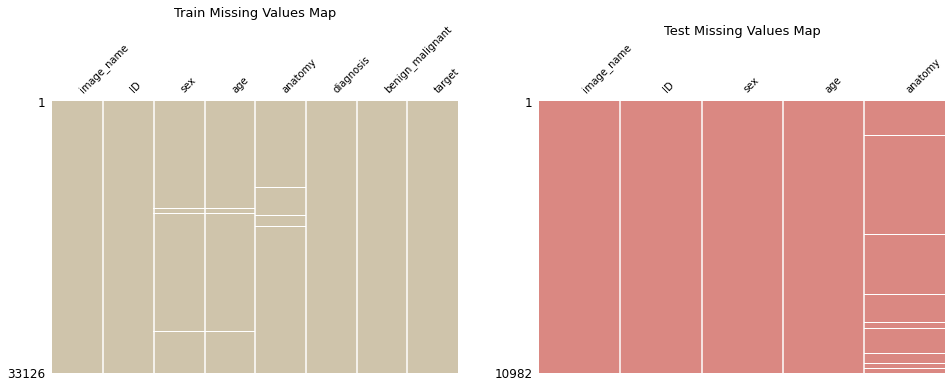

In [43]:
#visualize

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 5))

msno.matrix(train_df, ax = ax1, color=(207/255, 196/255, 171/255), fontsize=10)
msno.matrix(test_df, ax = ax2, color=(218/255, 136/255, 130/255), fontsize=10)

ax1.set_title('Train Missing Values Map', fontsize = 13)
ax2.set_title('Test Missing Values Map', fontsize = 13);

<p>One of the key findings for me was that for highly biased data sets one needs to do either overfitting or underfitting. 
    
    Many sklearn algorithms assume gaussian distribution of features. 
    
    Initially in learning phase I got excellent results, but competition evaluations were awful. 
    
    This is because a model that always or almost always predicts 'benign' is almost always right. Here we just look at the distribution to see it in more details </p>

In [44]:
#how much there is malign entries versus normal 
bl=len(train_df[train_df['benign_malignant']=='benign'])
ml=len(train_df[train_df['benign_malignant']=='malignant'])
print ("benign data", bl)
print ("malignant", ml)
print (" amount of malignant in percentage {:f} ".format((ml/bl)*100))

benign data 32542
malignant 584
 amount of malignant in percentage 1.794604 


<p> 
    
I use median age to fill in the missing age fields:</p>

In [45]:
#median age => use for missing age parameter
pd.DataFrame.median(train_df["age"])


50.0

In [46]:
#division of data
men_c=len(train_df[train_df['sex']=='male'])
women_c=len(train_df[train_df['sex']=='female'])
print ("Training data set: men {:d} {:f}% women {:d} {:f}%\n ".format(men_c, men_c/train_size *100, women_c, women_c/train_size*100))

#what are the unique values for anatomy
print ("Training data set anatomies: ", train_df.anatomy.unique())

#categories for age
print ("Training data set age buckets: ", train_df.age.unique())

Training data set: men 17080 51.560708% women 15981 48.243072%
 
Training data set anatomies:  ['head/neck' 'upper extremity' 'lower extremity' 'torso' nan 'palms/soles'
 'oral/genital']
Training data set age buckets:  [45. 50. 55. 40. 25. 35. 30. 75. 70. 65. 60. nan 80. 20. 85. 15. 90. 10.
  0.]


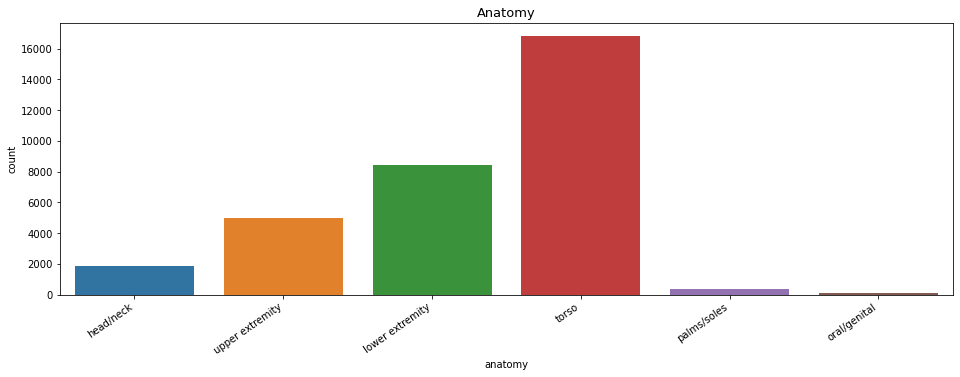

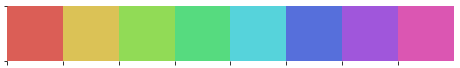

In [47]:
#Visualize anatomies in training data set

f, ax1 = plt.subplots(1, figsize = (16, 5))
ax1.set_title('Anatomy', fontsize=13)
sns.palplot(sns.color_palette("hls", 8))
a = sns.countplot(train_df['anatomy'], ax = ax1)
a.set_xticklabels(a.get_xticklabels(), rotation=35, ha="right")

sns.despine(left=True, bottom=True);

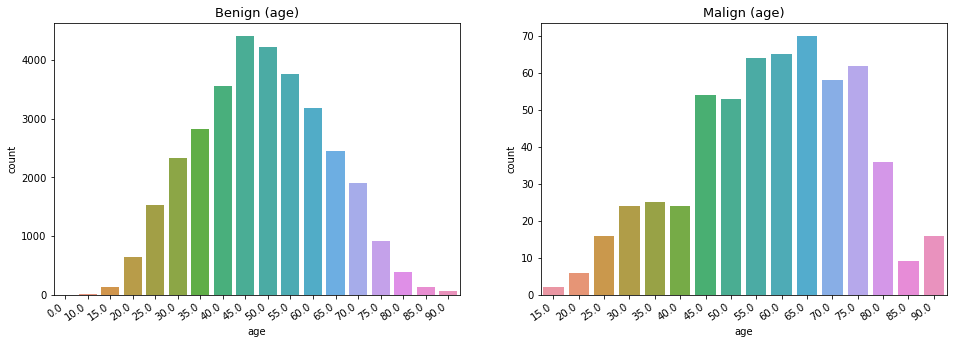

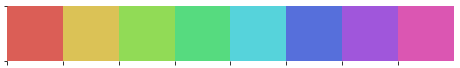

In [48]:
#Visualize age buckets in training normal and malign cases in training data set

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 5))
ax1.set_title('Benign (age)', fontsize=13)
ax2.set_title('Malign (age)', fontsize=13)
sns.palplot(sns.color_palette("hls", 8))
a1 = sns.countplot(train_df[train_df['benign_malignant']=='benign']['age'], ax = ax1)
a1.set_xticklabels(a1.get_xticklabels(), rotation=35, ha="right")
a2 = sns.countplot(train_df[train_df['benign_malignant']=='malignant']['age'], ax = ax2)
a2.set_xticklabels(a2.get_xticklabels(), rotation=35, ha="right")

sns.despine(left=True, bottom=True);

Malignant folks are older based on above diagrams.

<p> This being my first time for doing image analytics, I looked around the net how people are doing it. This example seemed most interesting: features from https://gogul.dev/software/image-classification-python
    </p>

In [49]:
def fd_histogram(image, mask=None):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()
    #return np.array([])

In [50]:
# feature-descriptor-2: Haralick Texture
def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick

In [51]:
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

<p>
Checking size of resulting feature vectors
</p>

In [52]:

im_name = '../input/siim-isic-melanoma-classification/jpeg/train/'+'ISIC_2637011'+'.jpg'
#img1 = cv2.resize(cv2.imread(im_name), rz)
img1 = cv2.imread(im_name)
fv_hu_moments = fd_hu_moments(img1)
print ("hu", fv_hu_moments.shape)
fv_haralick   = fd_haralick(img1)
print ("fv_haralick", fv_haralick.shape)
fv_histogram  = fd_histogram(img1)
print ("fv_histogram", fv_histogram.shape)

img2 = cv2.resize(cv2.imread(im_name), rz, Image.ANTIALIAS)
fd2, hog_image = hog (img2, orientations=8, \
                      pixels_per_cell=(ppc,ppc), \
                      cells_per_block=(4,4), \
                      block_norm='L2', visualize=True)

print ("hoc", fd2.shape)

hu (7,)
fv_haralick (13,)
fv_histogram (512,)
hoc (128,)


<p> 
The data set is very large and I could not load it on kaggle kernels before timeout so I did the loading on my machine. Took about 3-4 hours for the training set. 
    
It took me far too long to realize that instead of loading the data multiple times, I should store to a single file the results and load them in the beginning of the Notebook. I found pickle and used that. Later learned that you can also save directly numpys arrays. Simple realizations often take the longest time...
    
I also tried hog for image classification. Results were not as good as with the other paramter set. On HOG see for example: https://www.analyticsvidhya.com/blog/2019/09/feature-engineering-images-introduction-hog-feature-descriptor/
    </p>

In [53]:

# features from https://gogul.dev/software/image-classification-python

def load_data(df, im_path):
    l_data = []
    for image_id in tqdm(df['image_name'].head(devel_batch)):
        im_name = im_path+image_id+'.jpg'
        img1= cv2.imread(im_name)
        fv_hu_moments = fd_hu_moments(img1)
        fv_haralick   = fd_haralick(img1)
        img1 = cv2.resize(img1, rz, Image.ANTIALIAS)
        #img1 = img1.reshape(img1.shape[0]*img1.shape[1]*img1.shape[2],1).T
        ####################################
        # Global Feature extraction
        ####################################
        fv_histogram  = fd_histogram(img1)
        #fd, hog_image = hog (img1, orientations=8, \
        #                      pixels_per_cell=(ppc,ppc), \
        #                      cells_per_block=(4,4), \
        #                      block_norm='L2', visualize=True)
        #l_data.append(fd)
        ###################################
        # Concatenate global features
        ###################################
        fd = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
        ###################################
        # Concatenate global features
        ###################################
        l_data.append(fd)
    l_data = pd.DataFrame(np.vstack(l_data))
    
    #l_data = pd.DataFrame(np.vstack(l_data))
    return l_data 


(128,)

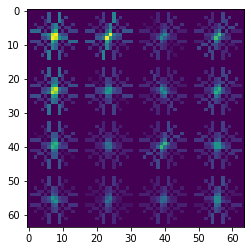

In [54]:

im_name = '../input/siim-isic-melanoma-classification/jpeg/train/'+'ISIC_2637011'+'.jpg'
img1 = cv2.resize(cv2.imread(im_name), rz)
#img1 = cv2.resize(cv2.imread(im_name), (128,128))
fd, hog_image = hog (img1, orientations=8, \
                     pixels_per_cell=(ppc,ppc), \
                    cells_per_block=(4,4), \
                    block_norm='L2', visualize=True)

plt.imshow(hog_image)
fd.shape

In [55]:

if (first_run==True):
    x_data_df_t = load_data(train_df, '../input/siim-isic-melanoma-classification/jpeg/train/')
    x_data_df_t.to_pickle("sk_x_data_df.pickle")
    x_data_df=x_data_df_t


In [56]:
x_data_df_t.head()

,0,1,2,3,4,5,6,7,8,9,...,522,523,524,525,526,527,528,529,530,531
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,2.531280,-0.509548,0.999305,0.001040,1.470424e-07,6.451490e-13,1.376970e-12,1.127557e-24,5.172563e-16,6.426276e-25
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000564,0.0,0.0,...,2.395215,-0.491523,0.998734,0.000959,1.192127e-07,5.965079e-13,5.193220e-13,2.737410e-25,1.792567e-16,9.280082e-26
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,2.375689,-0.445850,0.996287,0.001297,4.348466e-07,3.844822e-13,7.675705e-13,2.470557e-25,4.892263e-16,3.359108e-25
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,3.234502,-0.430486,0.998474,0.002667,1.884740e-06,1.285671e-10,2.128041e-10,2.499281e-20,2.662144e-13,-2.478621e-20
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,2.208043,-0.528525,0.999122,0.000925,1.155802e-07,3.998146e-13,1.255273e-13,2.402617e-26,4.250125e-17,1.461355e-26


In [57]:

x_data_df_t["sex"]= train_df["sex"].head(devel_batch)
x_data_df_t["age"]= train_df["age"].head(devel_batch)
x_data_df_t["anatomy"]= train_df["anatomy"].head(devel_batch)

x_data_df_t.head()


,0,1,2,3,4,5,6,7,8,9,...,525,526,527,528,529,530,531,sex,age,anatomy
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.001040,1.470424e-07,6.451490e-13,1.376970e-12,1.127557e-24,5.172563e-16,6.426276e-25,male,45.0,head/neck
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000564,0.0,0.0,...,0.000959,1.192127e-07,5.965079e-13,5.193220e-13,2.737410e-25,1.792567e-16,9.280082e-26,female,45.0,upper extremity
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.001297,4.348466e-07,3.844822e-13,7.675705e-13,2.470557e-25,4.892263e-16,3.359108e-25,female,50.0,lower extremity
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.002667,1.884740e-06,1.285671e-10,2.128041e-10,2.499281e-20,2.662144e-13,-2.478621e-20,female,45.0,head/neck
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000925,1.155802e-07,3.998146e-13,1.255273e-13,2.402617e-26,4.250125e-17,1.461355e-26,female,55.0,upper extremity


In [58]:
x_data_df_t.sex[x_data_df_t.sex == 'male'] = 1
x_data_df_t.sex[x_data_df_t.sex == 'female'] = 2
x_data_df_t["sex"].fillna(1,inplace=True)
x_data_df_t["age"].fillna(50,inplace=True)
x_data_df_t.anatomy[x_data_df_t.anatomy == 'head/neck'] = 1
x_data_df_t.anatomy[x_data_df_t.anatomy == 'upper extremity'] = 2
x_data_df_t.anatomy[x_data_df_t.anatomy == 'lower extremity'] = 3
x_data_df_t.anatomy[x_data_df_t.anatomy == 'torso'] = 4
x_data_df_t.anatomy[x_data_df_t.anatomy == 'palms/soles'] = 5
x_data_df_t.anatomy[x_data_df_t.anatomy == 'oral/genital'] = 6 
x_data_df_t["anatomy"].fillna(4,inplace=True)

/Users/marttiylikoski/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/marttiylikoski/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/marttiylikoski/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

<p> in retrospect trying to scale parameters this way may have been an error as I suspect some parameters of meta data (age, sex etc.) have very large values still in relation to others. Just scale is different. Not sure if this had an impact after all or should i have scaled the individual features instead.</p>

In [60]:
from sklearn.preprocessing import MinMaxScaler
scaler            = MinMaxScaler(feature_range=(0, 1))
x_data_df = pd.DataFrame(scaler.fit_transform(x_data_df_t))

In [61]:
x_data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,525,526,527,528,529,530,531,532,533,534
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.048152,0.011369,0.000015,0.000029,0.002733,0.107603,0.724017,0.0,0.500000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000567,0.0,0.0,...,0.037023,0.009217,0.000014,0.000011,0.002733,0.107598,0.724017,1.0,0.500000,0.2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.083311,0.033622,0.000009,0.000016,0.002733,0.107603,0.724017,1.0,0.555556,0.4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.270808,0.145725,0.003034,0.004523,0.002747,0.111338,0.724000,1.0,0.500000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.032343,0.008936,0.000009,0.000003,0.002733,0.107597,0.724017,1.0,0.611111,0.2


In [62]:
if (first_run==True):
    competition_data_df = load_data(test_df, '../input/siim-isic-melanoma-classification/jpeg/test/')
    competition_data_df.to_pickle("sk_competition_data_df.pickle")

In [63]:
competition_data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,522,523,524,525,526,527,528,529,530,531
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.001451,0.000000,0.000000,...,2.859462,-0.474319,0.998827,0.000942,1.169525e-07,7.778038e-14,4.217969e-13,7.638687e-26,1.439586e-16,1.384744e-27
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,1.844828,-0.619691,0.999658,0.000848,9.749173e-08,3.773072e-14,3.384346e-14,1.099224e-27,1.011522e-17,5.042676e-28
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.001543,0.000000,0.000000,...,1.733073,-0.605602,0.999285,0.000801,8.694014e-08,3.549851e-14,2.784523e-15,1.584431e-29,2.086256e-19,-2.270176e-29
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,1.787767,-0.591990,0.999312,0.000825,9.407575e-08,4.372274e-14,1.052580e-14,3.657304e-29,2.761757e-18,2.228250e-28
4,0.001286,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.015437,0.026372,...,2.600175,-0.541288,0.999695,0.000934,1.278315e-07,1.144509e-12,5.982158e-13,1.541877e-25,1.806082e-16,-4.703628e-25


In [64]:
competition_data_df.shape


(10982, 532)

In [65]:
competition_data_df["sex"]= test_df["sex"].head(devel_batch)
competition_data_df["age"]= test_df["age"].head(devel_batch)
competition_data_df["anatomy"]= test_df["anatomy"].head(devel_batch)
competition_data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,525,526,527,528,529,530,531,sex,age,anatomy
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.001451,0.000000,0.000000,...,0.000942,1.169525e-07,7.778038e-14,4.217969e-13,7.638687e-26,1.439586e-16,1.384744e-27,male,70.0,NaN
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000848,9.749173e-08,3.773072e-14,3.384346e-14,1.099224e-27,1.011522e-17,5.042676e-28,male,40.0,lower extremity
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.001543,0.000000,0.000000,...,0.000801,8.694014e-08,3.549851e-14,2.784523e-15,1.584431e-29,2.086256e-19,-2.270176e-29,female,55.0,torso
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000825,9.407575e-08,4.372274e-14,1.052580e-14,3.657304e-29,2.761757e-18,2.228250e-28,female,50.0,torso
4,0.001286,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.015437,0.026372,...,0.000934,1.278315e-07,1.144509e-12,5.982158e-13,1.541877e-25,1.806082e-16,-4.703628e-25,female,45.0,lower extremity


In [66]:
competition_data_df[9000:9500]

,0,1,2,3,4,5,6,7,8,9,...,525,526,527,528,529,530,531,sex,age,anatomy
9000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.002048,3.257841e-07,7.190936e-11,2.814584e-11,-4.758196e-22,-7.398516e-15,1.173433e-21,female,45.0,upper extremity
9001,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000809,9.053593e-08,6.880166e-14,5.800838e-16,-2.618224e-30,-1.515940e-19,-2.564128e-30,female,35.0,torso
9002,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000838,8.854653e-08,1.535668e-14,3.586144e-14,5.356720e-28,1.056608e-18,6.490730e-28,male,45.0,lower extremity
9003,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000459,0.000000,0.000000,...,0.000862,1.017877e-07,3.007192e-14,7.798852e-15,7.633351e-29,2.428803e-18,9.185632e-29,female,35.0,torso
9004,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000827,5.212449e-08,1.841288e-13,6.567045e-13,6.432280e-26,1.123098e-16,2.191116e-25,male,25.0,torso
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9495,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.001131,1.739920e-07,2.940343e-13,1.530071e-13,3.156254e-26,6.141699e-17,7.553809e-27,female,30.0,lower extremity
9496,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.001660,7.591907e-07,9.013695e-13,1.219567e-12,1.122763e-24,1.062627e-15,-6.118905e-25,female,50.0,upper extremity
9497,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000574,0.000000,...,0.000978,1.495605e-07,1.300639e-12,1.559218e-12,1.783198e-24,3.439106e-16,1.323086e-24,male,40.0,torso
9498,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.001597,6.660308e-07,2.997117e-12,2.783499e-12,5.551254e-24,2.079048e-15,-5.815489e-24,male,45.0,lower extremity


In [67]:
competition_data_df.sex[competition_data_df.sex == 'male'] = 1
competition_data_df.sex[competition_data_df.sex == 'female'] = 2
competition_data_df["sex"].fillna(1, inplace=True)
competition_data_df["age"].fillna(70, inplace=True)
competition_data_df.anatomy[competition_data_df.anatomy == 'head/neck'] = 1
competition_data_df.anatomy[competition_data_df.anatomy == 'upper extremity'] = 2
competition_data_df.anatomy[competition_data_df.anatomy == 'lower extremity'] = 3
competition_data_df.anatomy[competition_data_df.anatomy == 'torso'] = 4
competition_data_df.anatomy[competition_data_df.anatomy == 'palms/soles'] = 5
competition_data_df.anatomy[competition_data_df.anatomy == 'oral/genital'] = 6 
competition_data_df["anatomy"].fillna(4, inplace=True)

competition_data_df.head()

/Users/marttiylikoski/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/marttiylikoski/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/marttiylikoski/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

,0,1,2,3,4,5,6,7,8,9,...,525,526,527,528,529,530,531,sex,age,anatomy
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.001451,0.000000,0.000000,...,0.000942,1.169525e-07,7.778038e-14,4.217969e-13,7.638687e-26,1.439586e-16,1.384744e-27,1,70.0,4
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000848,9.749173e-08,3.773072e-14,3.384346e-14,1.099224e-27,1.011522e-17,5.042676e-28,1,40.0,3
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.001543,0.000000,0.000000,...,0.000801,8.694014e-08,3.549851e-14,2.784523e-15,1.584431e-29,2.086256e-19,-2.270176e-29,2,55.0,4
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000825,9.407575e-08,4.372274e-14,1.052580e-14,3.657304e-29,2.761757e-18,2.228250e-28,2,50.0,4
4,0.001286,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.015437,0.026372,...,0.000934,1.278315e-07,1.144509e-12,5.982158e-13,1.541877e-25,1.806082e-16,-4.703628e-25,2,45.0,3


In [68]:
scaler            = MinMaxScaler(feature_range=(0, 1))
competition_data_df = pd.DataFrame(scaler.fit_transform(competition_data_df))

In [69]:
competition_data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,525,526,527,528,529,530,531,532,533,534
0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.001462,0.000000,0.000000,...,0.065297,0.025003,0.000010,6.831273e-05,0.367902,0.195109,0.086763,0.0,0.7500,0.6
1,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.040104,0.020842,0.000005,5.480197e-06,0.367902,0.195098,0.086763,0.0,0.3750,0.4
2,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.001555,0.000000,0.000000,...,0.027549,0.018586,0.000005,4.499236e-07,0.367902,0.195097,0.086763,1.0,0.5625,0.6
3,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.034014,0.020112,0.000006,1.703693e-06,0.367902,0.195097,0.086763,1.0,0.5000,0.6
4,0.00363,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.095514,0.092612,...,0.063043,0.027328,0.000150,9.688535e-05,0.367902,0.195112,0.086763,1.0,0.4375,0.4


In [70]:
y_data=train_df['target'].head(devel_batch)

In [71]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data_df, y_data, test_size=0.15, random_state=42)
number_of_train = x_train.shape[0]
number_of_test = x_test.shape[0]
print ("number of train", number_of_train)
print ("number of test", number_of_test)


number of train 28157
number of test 4969


In [72]:
np.unique(y_train)

array([0, 1])

In [73]:
number_of_competition = competition_data_df.shape[0]
print ("test dataset size", number_of_competition)
number_of_features = x_data_df.shape[0]
print ("features", number_of_features)

test dataset size 10982
features 33126


In [74]:
#calculate the training and validation errors
def train_error(model, x_train1, y_train1, x_test1, y_test1):
    train_pred = model.predict(x_train1)
    err_train = mean_squared_error(train_pred, y_train1.ravel())
    test_pred = model.predict(x_test1)
    err_val = mean_squared_error(test_pred, y_test1.ravel())
    print ("Training error", err_train)
    print ("Validation error", err_val)
    return err_val


In [75]:
def write_submission(fname, val_pred):
    print ("write")
    sample_submission = pd.read_csv("../input/siim-isic-melanoma-classification/sample_submission.csv")
    sample_submission["target"] = val_pred
    sample_submission.head()
    sample_submission.to_csv(fname, index=False)
    #division of data
    ben_c=len(sample_submission[sample_submission['target']==0])
    mal_c=len(sample_submission[sample_submission['target']==1])
    pred_size=val_pred.size
    print ("Prediction data set: benign {:d} {:f}% malign {:d} {:f}%\n ".format(ben_c, men_c/pred_size *100, mal_c, mal_c/pred_size*100))


<p> oversampling code is here: </p>

In [76]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.datasets import make_imbalance
from imblearn.over_sampling import ADASYN, SMOTE

# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy=1)

sampling_strategy = 'minority'

X_over, y_over = oversample.fit_resample(x_data_df, y_data)

<h4> when using the original data set with extremely high bias, the predictive models seem to work almost perfectly irrespective of the model. This is because just by predict all as non-malignant, the results are very good.
This analysis shows (somewhat hidden), that either oversampling or undersamping of test data set is needed </h4>

In [77]:
#to try out
# clf = [LinearDiscriminantAnalysis(solver = 'lsqr')
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))

/Users/marttiylikoski/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/Users/marttiylikoski/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/marttiylikoski/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to conver

write
Prediction data set: benign 10966 155.527226% malign 16 0.145693%
 
LR: 0.982491 (0.002584)
write
Prediction data set: benign 10935 155.527226% malign 47 0.427973%
 
LDA: 0.971653 (0.003448)


/Users/marttiylikoski/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


write
Prediction data set: benign 10969 155.527226% malign 13 0.118376%
 
KNN: 0.982099 (0.002523)


/Users/marttiylikoski/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


write
Prediction data set: benign 4277 155.527226% malign 6705 61.054453%
 
CART: 0.966431 (0.003808)


/Users/marttiylikoski/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


write
Prediction data set: benign 10981 155.527226% malign 1 0.009106%
 
RF: 0.982491 (0.002580)


/Users/marttiylikoski/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


write
Prediction data set: benign 10978 155.527226% malign 4 0.036423%
 
NB: 0.039486 (0.002432)


/Users/marttiylikoski/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


write
Prediction data set: benign 10982 155.527226% malign 0 0.000000%
 
SVM: 0.982370 (0.002545)


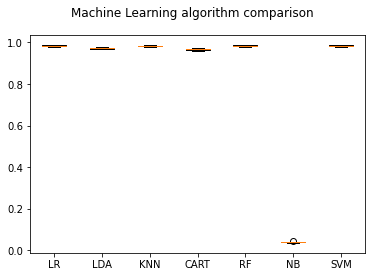

In [78]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
results=[]
names=[]
scoring    = "accuracy"

# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, x_data_df, y_data, cv=kfold, scoring=scoring)
    #val_pred = model.predict(train_vectors.todense())
    model.fit(x_data_df, y_data)
    val_pred = model.predict(competition_data_df)
    write_submission("submission"+name+".csv", val_pred)
    
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [79]:
#competition_data_df= competition_data_df_t
print(competition_data_df.shape)
print (x_data_df.shape)

(10982, 535)
(33126, 535)


In [80]:
x_data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,525,526,527,528,529,530,531,532,533,534
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.048152,0.011369,0.000015,0.000029,0.002733,0.107603,0.724017,0.0,0.500000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000567,0.0,0.0,...,0.037023,0.009217,0.000014,0.000011,0.002733,0.107598,0.724017,1.0,0.500000,0.2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.083311,0.033622,0.000009,0.000016,0.002733,0.107603,0.724017,1.0,0.555556,0.4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.270808,0.145725,0.003034,0.004523,0.002747,0.111338,0.724000,1.0,0.500000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.032343,0.008936,0.000009,0.000003,0.002733,0.107597,0.724017,1.0,0.611111,0.2


In [81]:
type(y_data)
y_data.shape

(33126,)

<p> Simple Logistic Regression is suprisingly good.</p>

In [82]:
model = LogisticRegression(random_state=seed).fit(X_over, y_over)
sc=model.score(X_over, y_over)
print ("score", sc)
val_predLR = model.predict(competition_data_df)
write_submission("submissionLR.csv", val_predLR)


score 0.7997357261385287
write
Prediction data set: benign 7672 155.527226% malign 3310 30.140229%
 


/Users/marttiylikoski/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


<p> Linear Discriminant analysis performs poorly. Just assumes everyone is benign.</p>

In [83]:
X_over, y_over = oversample.fit_resample(x_data_df, y_data)
model = LinearDiscriminantAnalysis().fit(X_over, y_over)
val_pred = model.predict(competition_data_df)
write_submission("submissionLDA.csv", val_pred)


write
Prediction data set: benign 10916 155.527226% malign 66 0.600983%
 


In [87]:
#Random guess that there are 20 classes of images that map either to benign or malign
model = KNeighborsClassifier(n_neighbors=80).fit(X_over, y_over)
val_pred = model.predict(competition_data_df)
write_submission("submissionKN.csv", val_pred)

write
Prediction data set: benign 6434 155.527226% malign 4548 41.413222%
 


<p> Decision Trees do not do very well </p>

In [90]:
model = DecisionTreeClassifier(random_state=seed, max_depth=100).fit(X_over, y_over)
val_pred = model.predict(competition_data_df)
write_submission("submissionCART.csv", val_pred)


write
Prediction data set: benign 10450 155.527226% malign 532 4.844291%
 


In [91]:
num_trees=500
model = RandomForestClassifier(n_estimators=num_trees, random_state=seed).fit(X_over, y_over)
val_pred = model.predict(competition_data_df)
write_submission("submissionRF.csv", val_pred)


write
Prediction data set: benign 10982 155.527226% malign 0 0.000000%
 


In [100]:
#Create a svm Classifier
model = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
model.fit(X_over, y_over)

#Predict the response for test dataset
y_pred = model.predict(competition_data_df)

write_submission("submissionSVC.csv", y_pred)

#debug infos
#competition_data_df[1000:2000]
#val_pred
print (np.unique(y_pred))



write
Prediction data set: benign 6966 155.527226% malign 4016 36.568931%
 
[0 1]


In [93]:
#works badly here
model = GaussianNB().fit(X_over, y_over)
val_pred = model.predict(competition_data_df)
write_submission("submissionGNB.csv", val_pred)

write
Prediction data set: benign 10978 155.527226% malign 4 0.036423%
 


In [99]:
model = SGDClassifier(random_state=42, max_iter=4000, tol=1e-3).fit(X_over, y_over)
val_predSGDC = model.predict(competition_data_df)
write_submission("submissionSGDC.csv", val_predSGDC)

print (np.unique(val_predSGDC))
competition_data_df.head()

write
Prediction data set: benign 6846 155.527226% malign 4136 37.661628%
 
[0 1]


,0,1,2,3,4,5,6,7,8,9,...,525,526,527,528,529,530,531,532,533,534
0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.001462,0.000000,0.000000,...,0.065297,0.025003,0.000010,6.831273e-05,0.367902,0.195109,0.086763,0.0,0.7500,0.6
1,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.040104,0.020842,0.000005,5.480197e-06,0.367902,0.195098,0.086763,0.0,0.3750,0.4
2,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.001555,0.000000,0.000000,...,0.027549,0.018586,0.000005,4.499236e-07,0.367902,0.195097,0.086763,1.0,0.5625,0.6
3,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.034014,0.020112,0.000006,1.703693e-06,0.367902,0.195097,0.086763,1.0,0.5000,0.6
4,0.00363,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.095514,0.092612,...,0.063043,0.027328,0.000150,9.688535e-05,0.367902,0.195112,0.086763,1.0,0.4375,0.4


In [157]:
x_data_df.head()


,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0.002177,0.063030,0.772754,0.067950,0.233189,0.637412,0.064708,0.742576,0.671939,0.141085,...,0.042916,0.012504,0.000011,0.000021,0.001170,0.043715,0.725605,0.0,0.500000,0.0
1,0.002162,0.022389,0.883522,0.047292,0.152089,0.696997,0.046346,0.670090,0.639900,0.115309,...,0.032208,0.010036,0.000010,0.000008,0.001170,0.043713,0.725605,1.0,0.500000,0.2
2,0.006659,0.005782,0.968411,0.050138,0.317472,0.590560,0.050166,0.566239,0.497458,0.268576,...,0.064687,0.017289,0.000004,0.000008,0.001170,0.043713,0.725605,1.0,0.555556,0.4
3,0.000874,0.081130,0.848927,0.134137,0.188897,0.267624,0.130044,0.827484,0.763074,0.124082,...,0.232412,0.077862,0.001161,0.002133,0.001171,0.044326,0.725599,1.0,0.500000,0.0
4,0.002812,0.015954,0.888968,0.035131,0.228265,0.740359,0.034522,0.656983,0.599616,0.151995,...,0.027696,0.009714,0.000006,0.000002,0.001170,0.043712,0.725605,1.0,0.611111,0.2


In [158]:
competition_data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0.003042,0.310864,0.188976,0.117601,0.235277,0.737883,0.098584,0.714404,0.678594,0.146591,...,0.056345,0.024921,0.000008,4.799774e-05,0.104432,0.018814,0.086229,0.0,0.7500,0.6
1,0.008541,0.034739,0.827359,0.060948,0.484274,0.824641,0.059006,0.613950,0.479803,0.383097,...,0.031851,0.020255,0.000004,3.859858e-06,0.104432,0.018803,0.086229,0.0,0.3750,0.4
2,0.011091,0.020440,0.782918,0.026421,0.455606,0.879239,0.025328,0.517280,0.422112,0.328086,...,0.019684,0.017733,0.000004,3.180128e-07,0.104432,0.018802,0.086229,1.0,0.5625,0.6
3,0.007912,0.007991,0.902356,0.025242,0.408440,0.847571,0.024921,0.548808,0.449256,0.322062,...,0.025943,0.019437,0.000004,1.196080e-06,0.104432,0.018803,0.086229,1.0,0.5000,0.6
4,0.004031,0.008077,0.997320,0.578180,0.404328,0.556645,0.578475,0.799193,0.582835,0.299069,...,0.042125,0.006863,0.000092,4.559362e-05,0.104432,0.018806,0.086229,1.0,0.4375,0.4


Trying grid search to see if it improves the best models.
This does not seem to happen.

In [74]:
from sklearn.model_selection import GridSearchCV
models = []
LRparams = {
    "C":np.logspace(-3,3,7), 
    "penalty":["l1","l2"]
}
SGDCparams = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "none"],
}


models.append(('LRClassifier', LogisticRegression(), LRparams )) 
models.append(('SGDClassifier', SGDClassifier(), SGDCparams )) 

#need to add search parameters to each model type
#from sklearn.model_selection import GridSearchCV
for name, model, parameters in models:
    print ("model: ", name)
    clf = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
    clf = clf.fit(X_over, y_over,)
    val_pred = clf.predict(competition_data_df)
    write_submission("submission"+name+".csv", val_pred)

model:  LRClassifier


/Users/marttiylikoski/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


write
Prediction data set: benign 7852 155.527226% malign 3130 28.501184%
 
model:  SGDClassifier
write
Prediction data set: benign 9489 155.527226% malign 1493 13.594974%
 


In [245]:
pred=np.vstack((val_predSGDC, val_predLR, y_pred)).T
pred[:,1].shape
n=pred.sum(axis=1)
np.count_nonzero(n == 2)


343